# What's the Price of Wheat?

<img src="http://www.ictinternational.com/content/uploads/2015/02/wheat1.jpg" width=640 height=480/>

## Project Background and Motivation

We chose to create a predictor of the stock price of wheat because of the ever-pervasive fluctuation in food prices. Wheat is among one of the most fundamental agricultural commodities in the United States, so understanding and ultimately predicting the price of this commodity will allow us to understand an essential part of our economic ecosystem. Our team has diverse backgrounds in engineering and science, so we wanted to choose a topic that has profound global implications. One of the grand challenges identified by the leaders of the U.N. and world bank is the shortage of food in our ever growing population. We thought it would be interesting for us to be able to build predictive forecasting of the stock price of this key commodity as this framework is a proof of principle for forecasting the price of any other agricultural commodity of choice.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# 1. Cleaning Data
We will be using precipitation, temperature, inflation, and the price of corn to predict the price of wheat. 

# INCLUDE REASONS WHY HERE!!!! 

Let's clean our data before using it in our model.

### 1.1 Precipitation Data

In [2]:
dirtyprecdf=pd.read_csv("data/stationprec.csv")
dirtyprecdf.head(10)

,Station ID,Year,Jan,Feb,March,April,May,June,July,August,September,October,November,December
0,AQC00914000,1981,4279,3745,10762,6067,4096,3606,6203,5292,3092,6866,7163,7866
1,AQC00914000,1982,5039,9643,3211,2016,3355,2827,3199,9356,4150,6418,3965,1595
2,AQC00914000,1983,3351,2971,3044,2642,1644,1717,1020,1788,3433,6801,2531,7242
3,AQC00914000,1984,3368,3538,8187,2715,2916,3288,1246,3391,2932,6578,4787,9787
4,AQC00914000,1985,5202,3078,3279,8414,2884,4787,3447,3193,5296,5410,3950,1651
5,AQC00914000,1986,8573,4212,2799F,7095F,5012F,3135F,3878F,2989F,6368F,4740F,4312F,8310F
6,AQC00914000,1987,5146,7648,3954F,3573F,3118F,2788F,2043F,3498F,841,2669,2298,6208F
7,AQC00914000,1988,3336F,4798,4908,4400F,4297F,2817,3878,2548F,3792,4645,5969F,8915F
8,AQC00914000,1989,5523F,5806F,3273F,5388F,3672F,3079F,4166F,209,788,4982,6379,3731
9,AQC00914000,1990,4932,6857,3288,4518,1635,3598,2214,1541,2611,5439,4525,3530


There are a few things in the precipitation dataframe that we want to change. The numbers in each month need to be interpreted, since it is often in the form ####F. There are also some results with -9999M, which we want to get rid of, since those indicate missing data. We want to get rid of the letters and turn the number into an understandable inch unit. According to the readme from our source, each number is the number of 1/100ths of an inch (e.g. 1486 = 14.86 inches)

In [3]:
precdf=dirtyprecdf
# remove the -9999M rows, the F, and turn numbers to inch values
for col in precdf:
    if (col!="Station ID" and col!= "Year"):
        precdf= precdf[precdf[col] != '-9999M']
        precdf[col]=precdf[col].map(lambda x: x.rstrip("F"))
        precdf[col]=precdf[col].map(lambda x: float(x)/100.00)
precdf.head(10)

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Station ID,Year,Jan,Feb,March,April,May,June,July,August,September,October,November,December
0,AQC00914000,1981,42.79,37.45,107.62,60.67,40.96,36.06,62.03,52.92,30.92,68.66,71.63,78.66
1,AQC00914000,1982,50.39,96.43,32.11,20.16,33.55,28.27,31.99,93.56,41.50,64.18,39.65,15.95
2,AQC00914000,1983,33.51,29.71,30.44,26.42,16.44,17.17,10.20,17.88,34.33,68.01,25.31,72.42
3,AQC00914000,1984,33.68,35.38,81.87,27.15,29.16,32.88,12.46,33.91,29.32,65.78,47.87,97.87
4,AQC00914000,1985,52.02,30.78,32.79,84.14,28.84,47.87,34.47,31.93,52.96,54.10,39.50,16.51
5,AQC00914000,1986,85.73,42.12,27.99,70.95,50.12,31.35,38.78,29.89,63.68,47.40,43.12,83.10
6,AQC00914000,1987,51.46,76.48,39.54,35.73,31.18,27.88,20.43,34.98,8.41,26.69,22.98,62.08
7,AQC00914000,1988,33.36,47.98,49.08,44.00,42.97,28.17,38.78,25.48,37.92,46.45,59.69,89.15
8,AQC00914000,1989,55.23,58.06,32.73,53.88,36.72,30.79,41.66,2.09,7.88,49.82,63.79,37.31
9,AQC00914000,1990,49.32,68.57,32.88,45.18,16.35,35.98,22.14,15.41,26.11,54.39,45.25,35.30


Station IDs aren't really helpful to us, and instead we want to convert this to the states that each station is in.

In [4]:
statiddf=pd.read_csv("data/statid.csv")
statiddf=statiddf[['Station ID', 'State']]
statid={}
for index, row in statiddf.iterrows():
    statid[row['Station ID']]=row['State']
# hard code some values that aren't in the station id list, but appear in precdf
statid['USC00085612']='FL'

In [5]:
state = []
for id in precdf['Station ID']:
    state.append(statid[id])
precdf['state'] = state
precdf=precdf.drop('Station ID', axis=1)
precdf.head()

,Year,Jan,Feb,March,April,May,June,July,August,September,October,November,December,state
0,1981,42.79,37.45,107.62,60.67,40.96,36.06,62.03,52.92,30.92,68.66,71.63,78.66,AS
1,1982,50.39,96.43,32.11,20.16,33.55,28.27,31.99,93.56,41.50,64.18,39.65,15.95,AS
2,1983,33.51,29.71,30.44,26.42,16.44,17.17,10.20,17.88,34.33,68.01,25.31,72.42,AS
3,1984,33.68,35.38,81.87,27.15,29.16,32.88,12.46,33.91,29.32,65.78,47.87,97.87,AS
4,1985,52.02,30.78,32.79,84.14,28.84,47.87,34.47,31.93,52.96,54.10,39.50,16.51,AS


Now let's modify the column names. We want to standardize the name of months to the abbreviated month names.

In [6]:
precdf.columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 
                  'Sep', 'Oct', 'Nov', 'Dec', 'State']
precdf.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,State
0,1981,42.79,37.45,107.62,60.67,40.96,36.06,62.03,52.92,30.92,68.66,71.63,78.66,AS
1,1982,50.39,96.43,32.11,20.16,33.55,28.27,31.99,93.56,41.50,64.18,39.65,15.95,AS
2,1983,33.51,29.71,30.44,26.42,16.44,17.17,10.20,17.88,34.33,68.01,25.31,72.42,AS
3,1984,33.68,35.38,81.87,27.15,29.16,32.88,12.46,33.91,29.32,65.78,47.87,97.87,AS
4,1985,52.02,30.78,32.79,84.14,28.84,47.87,34.47,31.93,52.96,54.10,39.50,16.51,AS


Now group the rows by state and year.

In [7]:
prec_grouped = precdf.groupby(['State','Year']).mean().reset_index()
prec_grouped.head(10)

,State,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,AK,1981,15.683362,8.257069,8.708879,3.853276,4.915259,6.550172,10.535862,15.486552,12.651207,12.820948,12.226121,7.486121
1,AK,1982,5.100342,3.618462,5.281624,5.847863,6.187179,5.819829,7.964359,6.752137,15.152222,11.733419,9.297863,9.896068
2,AK,1983,7.984655,6.574655,2.432241,7.119828,6.262931,4.087155,6.538879,13.819310,10.171466,13.382414,8.525172,3.358017
3,AK,1984,12.432069,8.805259,6.767759,5.168362,4.187759,6.101121,8.322500,10.346638,8.663448,9.372586,7.268966,10.093190
4,AK,1985,15.284348,7.119652,8.681217,5.548087,5.936609,7.537130,5.375565,10.198435,13.984087,9.077913,4.656261,15.266783
5,AK,1986,12.364872,6.162650,6.593077,4.190427,4.491368,4.831368,7.465470,11.689744,8.029231,18.506838,10.268120,15.018718
6,AK,1987,13.020000,7.321282,5.140513,5.975641,6.503419,10.063504,6.694017,5.087863,17.302222,17.963675,13.330855,10.894957
7,AK,1988,7.215470,9.894017,9.811880,7.323504,6.320000,6.074530,6.445641,11.865556,10.154017,14.196752,10.109829,13.272650
8,AK,1989,8.603621,2.369569,2.484310,4.185862,7.217845,6.950517,6.059138,10.700517,14.211724,15.089397,10.749397,15.118621
9,AK,1990,9.548205,7.374872,7.928034,3.385556,3.875385,5.460855,7.563504,10.194103,18.809231,10.304786,6.216667,11.274872


Store the cleaned precipitation data into csv file so we don't have to run this every time.

In [8]:
prec_grouped.to_csv('cleaned_data/precdf.csv')

### 1.2 Temperature Data

Now that we have cleaned the data for the precipitation, we follow a similar procedure for temperature. Since the temperature data is from the same source, we will follow almost exactly the same procedure.

In [9]:
dirtytempdf=pd.read_csv("data/stationtemp.csv")
dirtytempdf.head(10)

//anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


,Station,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,AQW00061705,1981,2750,2700,2690,2670,2685,2605,2600,2610,2685,2645,2700,2710
1,AQW00061705,1982,2765,2675,2785,2750,2700,2675,2585,2600,2610,2695,2665,2715
2,AQW00061705,1983,2775,2850,2755,2720,2715,2635,2580,2560,2665,2630,2680,2735
3,AQW00061705,1984,2700,2740,2725,2745,2750,2685,2600,2640,2630,2630,2710,2670
4,AQW00061705,1985,2675,2745,2780,2700,2685,2660,2630,2650,2640,2700,2685,2750
5,AQW00061705,1986,2720,2745,2775,2720,2690,2695,2615,2560,2650,2720,2755,2750
6,AQW00061705,1987,2750,2800,2780,2770,2680,2575,2560,2555,2640,2675,2755,2780
7,AQW00061705,1988,2800,2810,2815,2735,2750,2735,2630,2680,2660,2660,2640,2650
8,AQW00061705,1989,2640,2680,2730,2700,2685,2665,2580,2640,2750,2715,2685,2675
9,AQW00061705,1990,2740,2735,2745,2685,2760,2680,2665,2665,2675,2735,2750,2755


In [10]:
# remove the -9999M rows, and convert to degrees celsius
for col in dirtytempdf:
    if (col!="Station" and col!= "Year"):
        dirtytempdf= dirtytempdf[dirtytempdf[col] != '-9999M']
        dirtytempdf[col]=dirtytempdf[col].map(lambda x: float(x)/100.00)

In [11]:
state = []
for id in dirtytempdf['Station']:
    state.append(statid[id])
dirtytempdf['State'] = state
dirtytempdf=dirtytempdf.drop('Station', axis=1)
dirtytempdf.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,State
0,1981,27.50,27.00,26.90,26.70,26.85,26.05,26.00,26.1,26.85,26.45,27.00,27.10,AS
1,1982,27.65,26.75,27.85,27.50,27.00,26.75,25.85,26.0,26.10,26.95,26.65,27.15,AS
2,1983,27.75,28.50,27.55,27.20,27.15,26.35,25.80,25.6,26.65,26.30,26.80,27.35,AS
3,1984,27.00,27.40,27.25,27.45,27.50,26.85,26.00,26.4,26.30,26.30,27.10,26.70,AS
4,1985,26.75,27.45,27.80,27.00,26.85,26.60,26.30,26.5,26.40,27.00,26.85,27.50,AS


In [12]:
tdf=dirtytempdf.groupby(['State','Year']).mean().reset_index()
tdf.head(10)

,State,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,AK,1981,-7.316923,-10.849936,-2.146795,-0.466090,7.246795,11.301154,12.566090,11.463397,6.910577,-0.061474,-7.999615,-11.240769
1,AK,1982,-10.096667,-12.740577,-6.355897,-3.707115,4.874872,10.444679,13.082628,11.590128,7.221410,-3.105769,-10.229295,-7.180000
2,AK,1983,-10.949359,-9.052115,-6.856731,-1.559167,6.256795,11.532115,13.462115,11.002885,6.548077,-0.134551,-6.825641,-8.156731
3,AK,1984,-9.910449,-10.662051,-4.902692,-0.588718,6.524423,11.626667,13.034487,11.729359,7.952244,1.275385,-7.563333,-10.658910
4,AK,1985,-7.611731,-10.805769,-4.969167,-1.978077,6.095833,10.585897,13.630897,11.520577,6.658910,-2.034872,-10.239231,-7.453141
5,AK,1986,-14.249103,-9.054231,-8.436218,-1.005705,6.271795,11.427564,13.800705,11.938141,8.632692,0.615449,-9.357885,-6.661538
6,AK,1987,-11.177949,-13.390192,-5.334359,0.910128,7.198205,11.196282,13.571667,12.937628,7.433910,0.373910,-10.005577,-11.839038
7,AK,1988,-11.770385,-9.302564,-6.103590,0.414936,6.838333,11.586667,13.255641,11.353526,7.934808,-1.215641,-8.665321,-9.423782
8,AK,1989,-13.934968,-10.375097,-6.601097,0.337226,5.417097,11.458194,14.438710,12.680194,5.787161,-1.266968,-8.512065,-10.032129
9,AK,1990,-13.171731,-12.929231,-4.614231,2.455962,8.081154,12.093910,14.583205,12.959615,7.465449,0.566731,-9.072564,-9.837692


Store the cleaned temperature data into a csv file.

In [13]:
tdf.to_csv('cleaned_data/tempdf.csv')

### 1.3 Corn Price Data
Data obtained from: http://www.indexmundi.com/commodities/?commodity=corn&months=300.

In [14]:
cornprice_df=pd.read_csv("data/cornPrice_perMonth_1990_2015.csv")
cornprice_df.head()

,Maize (corn) - Monthly Price,Unnamed: 1,Unnamed: 2
0,Month,Price,Change
1,Nov-90,100,-
2,Dec-90,102.36,2.36%
3,Jan-91,105.51,3.08%
4,Feb-91,106.29,0.74%


We will split the first column into two separate columns for month and year.

In [15]:
# change column names
cornprice_df.columns = ['month-year', 'price', 'change']
# remove first row
cornprice_df = cornprice_df[~cornprice_df['month-year'].isin(['Month'])]
# add columns for month and year
month = []
year = []
for row in cornprice_df['month-year']:
    suffix_year = row.split('-')
    month.append(suffix_year[0])
    if suffix_year[1][0] == '9':
        year.append('19'+suffix_year[1])
    else:
        year.append('20'+suffix_year[1])
cornprice_df['month'] = month
cornprice_df['year'] = year
# remove month-year column 
cornprice_df = cornprice_df.drop('month-year', axis=1)
cornprice_df.head()

,price,change,month,year
1,100,-,Nov,1990
2,102.36,2.36%,Dec,1990
3,105.51,3.08%,Jan,1991
4,106.29,0.74%,Feb,1991
5,109.05,2.60%,Mar,1991


Store the cleaned corn price data into a csv file.

In [16]:
cornprice_df.to_csv('cleaned_data/cornpricedf.csv')

### 1.4 Inflation Data
Data obtained from: http://inflationdata.com/Inflation/Inflation_Rate/Monthly_Inflation.aspx

In [17]:
inflation_df = pd.read_csv("data/inflationdata.csv")
inflation_df.head()

,Unnamed: 0,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1990,1.03%,0.47%,0.55%,0.16%,0.23%,0.54%,0.38%,0.92%,0.84%,0.60%,0.22%,0.00%
1,1991,0.60%,0.15%,0.15%,0.15%,0.30%,0.29%,0.15%,0.29%,0.44%,0.15%,0.29%,0.07%
2,1992,0.15%,0.36%,0.51%,0.14%,0.14%,0.36%,0.21%,0.28%,0.28%,0.35%,0.14%,-0.07%
3,1993,0.49%,0.35%,0.35%,0.28%,0.14%,0.14%,0.00%,0.28%,0.21%,0.41%,0.07%,0.00%
4,1994,0.27%,0.34%,0.34%,0.14%,0.07%,0.34%,0.27%,0.40%,0.27%,0.07%,0.13%,0.00%


We will update the column names and remove the '%' from each cell.

In [18]:
# rename column names for easy calling (retrieval)
inflation_df.columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                        'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
# Iterate through the data and remove the % from the inflation rates to only have the values of percentages in the table
for col in inflation_df:
        if (col!="Year"):
            inflation_df[col]=inflation_df[col].map(lambda x: x.replace("%", ""))
inflation_df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sept,Oct,Nov,Dec
0,1990,1.03,0.47,0.55,0.16,0.23,0.54,0.38,0.92,0.84,0.60,0.22,0.00
1,1991,0.60,0.15,0.15,0.15,0.30,0.29,0.15,0.29,0.44,0.15,0.29,0.07
2,1992,0.15,0.36,0.51,0.14,0.14,0.36,0.21,0.28,0.28,0.35,0.14,-0.07
3,1993,0.49,0.35,0.35,0.28,0.14,0.14,0.00,0.28,0.21,0.41,0.07,0.00
4,1994,0.27,0.34,0.34,0.14,0.07,0.34,0.27,0.40,0.27,0.07,0.13,0.00


Store the cleaned inflation data into a csv file

In [19]:
inflation_df.to_csv('cleaned_data/inflationdf.csv')

### 1.5 Wheat Price Data
Data obtained from: http://www.indexmundi.com/commodities/?commodity=wheat&months=300.

In [20]:
price_df=pd.read_csv("data/price_of_wheat.csv")
price_df.head()

,Wheat - Monthly Price,Unnamed: 1,Unnamed: 2
0,Month,Price,Change
1,Nov-90,112.8,-
2,Dec-90,113.17,0.33%
3,Jan-91,111.33,-1.63%
4,Feb-91,113.91,2.32%


In [21]:
# change column names
price_df.columns = ['month-year', 'price', 'change']
# remove first row
price_df = price_df[~price_df['month-year'].isin(['Month'])]
# add columns for month and year
month = []
year = []
for row in price_df['month-year']:
    time = row.split('-')
    month.append(time[0])
    if time[1][0] == '9':
        year.append('19'+time[1])
    else:
        year.append('20'+time[1])
price_df['month'] = month
price_df['year'] = year
# remove month-year column
price_df = price_df.drop('month-year', axis=1)
price_df.head()

,price,change,month,year
1,112.8,-,Nov,1990
2,113.17,0.33%,Dec,1990
3,111.33,-1.63%,Jan,1991
4,113.91,2.32%,Feb,1991
5,119.42,4.84%,Mar,1991


Store the cleaned wheat price data into a csv file.

In [22]:
price_df.to_csv('cleaned_data/wheatprice_df.csv')

# 2. Exploratory Analysis
Now we will visualize the data.

### 2.1 Visualizing Precipation Data
Here we will visualize precipation data with a heat map and bar graph.

In [23]:
%matplotlib inline
import json
from collections import defaultdict
from matplotlib import rcParams

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

Code to plot State Chloropleth maps in matplotlib. "make_map" is the function actually used to create the maps.

In [24]:
#this mapping between states and abbreviations will come in handy later
states_abbrev = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [25]:
#adapted from  https://github.com/dataiap/dataiap/blob/master/resources/util/map_util.py

#load in state geometry
state2poly = defaultdict(list)

data = json.load(file("data/us-states.json"))
for f in data['features']:
    state = states_abbrev[f['id']]
    geo = f['geometry']
    if geo['type'] == 'Polygon':
        for coords in geo['coordinates']:
            state2poly[state].append(coords)
    elif geo['type'] == 'MultiPolygon':
        for polygon in geo['coordinates']:
            state2poly[state].extend(polygon)

            
def draw_state(plot, stateid, **kwargs):
    """
    draw_state(plot, stateid, color=..., **kwargs)
    
    Automatically draws a filled shape representing the state in
    subplot.
    The color keyword argument specifies the fill color.  It accepts keyword
    arguments that plot() accepts
    """
    for polygon in state2poly[stateid]:
        xs, ys = zip(*polygon)
        plot.fill(xs, ys, **kwargs)

        
def make_map(states, label):
    """
    Draw a cloropleth map, that maps data onto the United States
    
    Inputs
    -------
    states : Column of a DataFrame
        The value for each state, to display on a map
    label : str
        Label of the color bar

    Returns
    --------
    The map
    """
    fig = plt.figure(figsize=(12, 9))
    ax = plt.gca()

    if states.max() < 2: # colormap for election probabilities 
        cmap = cm.RdBu
        vmin, vmax = 0, 1
    else:  # colormap for electoral votes
        cmap = cm.binary
        vmin, vmax = 0, states.max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    skip = set(['National', 'District of Columbia', 'Guam', 'Puerto Rico',
                'Virgin Islands', 'American Samoa', 'Northern Mariana Islands'])
    for state in states_abbrev.values():
        if state in skip:
            continue
        if state not in states:
            continue
        color = cmap(norm(states.ix[state]))
        draw_state(ax, state, color = color, ec='k')

    #add an inset colorbar
    ax1 = fig.add_axes([0.45, 0.70, 0.4, 0.02])    
    cb1=mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                  norm=norm,
                                  orientation='horizontal')
    ax1.set_title(label)
    remove_border(ax, left=False, bottom=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-180, -60)
    ax.set_ylim(15, 75)
    return ax

In [26]:
prec = pd.read_csv("cleaned_data/precdf.csv")
prec.head(10)

,Unnamed: 0,State,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,0,AK,1981,15.683362,8.257069,8.708879,3.853276,4.915259,6.550172,10.535862,15.486552,12.651207,12.820948,12.226121,7.486121
1,1,AK,1982,5.100342,3.618462,5.281624,5.847863,6.187179,5.819829,7.964359,6.752137,15.152222,11.733419,9.297863,9.896068
2,2,AK,1983,7.984655,6.574655,2.432241,7.119828,6.262931,4.087155,6.538879,13.819310,10.171466,13.382414,8.525172,3.358017
3,3,AK,1984,12.432069,8.805259,6.767759,5.168362,4.187759,6.101121,8.322500,10.346638,8.663448,9.372586,7.268966,10.093190
4,4,AK,1985,15.284348,7.119652,8.681217,5.548087,5.936609,7.537130,5.375565,10.198435,13.984087,9.077913,4.656261,15.266783
5,5,AK,1986,12.364872,6.162650,6.593077,4.190427,4.491368,4.831368,7.465470,11.689744,8.029231,18.506838,10.268120,15.018718
6,6,AK,1987,13.020000,7.321282,5.140513,5.975641,6.503419,10.063504,6.694017,5.087863,17.302222,17.963675,13.330855,10.894957
7,7,AK,1988,7.215470,9.894017,9.811880,7.323504,6.320000,6.074530,6.445641,11.865556,10.154017,14.196752,10.109829,13.272650
8,8,AK,1989,8.603621,2.369569,2.484310,4.185862,7.217845,6.950517,6.059138,10.700517,14.211724,15.089397,10.749397,15.118621
9,9,AK,1990,9.548205,7.374872,7.928034,3.385556,3.875385,5.460855,7.563504,10.194103,18.809231,10.304786,6.216667,11.274872


We will remove non 50 state entries such as Puerto Rico and then visualize precipitation in a heat map of the United States.

In [27]:
for col in prec:
    if (col=='State'):
        prec= prec[(prec[col] != 'FM') & (prec[col] != 'UM')
                   & (prec[col] != 'MH') & (prec[col] != 'PW')]

In [28]:
def make_map_prec(year, start_month, end_month): 
    input_df = prec.loc[prec['Year'] == year]
    input_df['cumulative_rainfall'] = (prec.ix[:,start_month:end_month]).sum(axis=1)
    for index, row in input_df.iterrows():
        state_full=states_abbrev[row['State']]
        input_df['State'][index]=state_full
    make_map(input_df.set_index('State').cumulative_rainfall,"Total Rainfall in Inches by State from "+str(start_month)+" to "+str(end_month)+" "+str(year))

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
//anaconda/lib/python2.7/sit

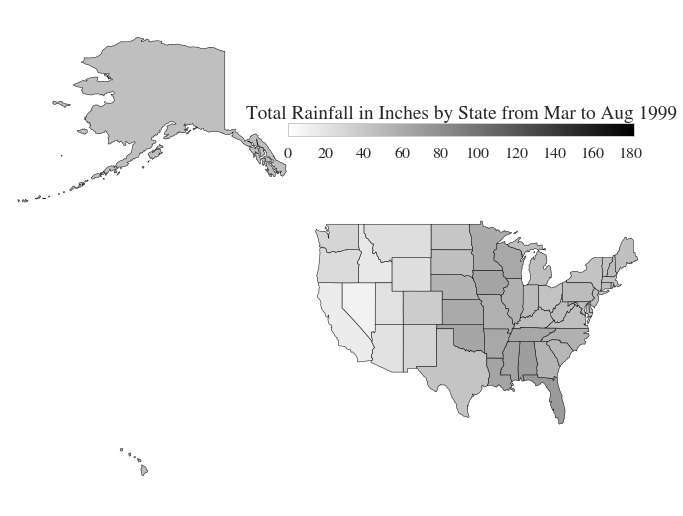

In [29]:
make_map_prec(1999,'Mar','Aug')

For a more quantitative understanding of the precipation in each state, we will make a bar graph.

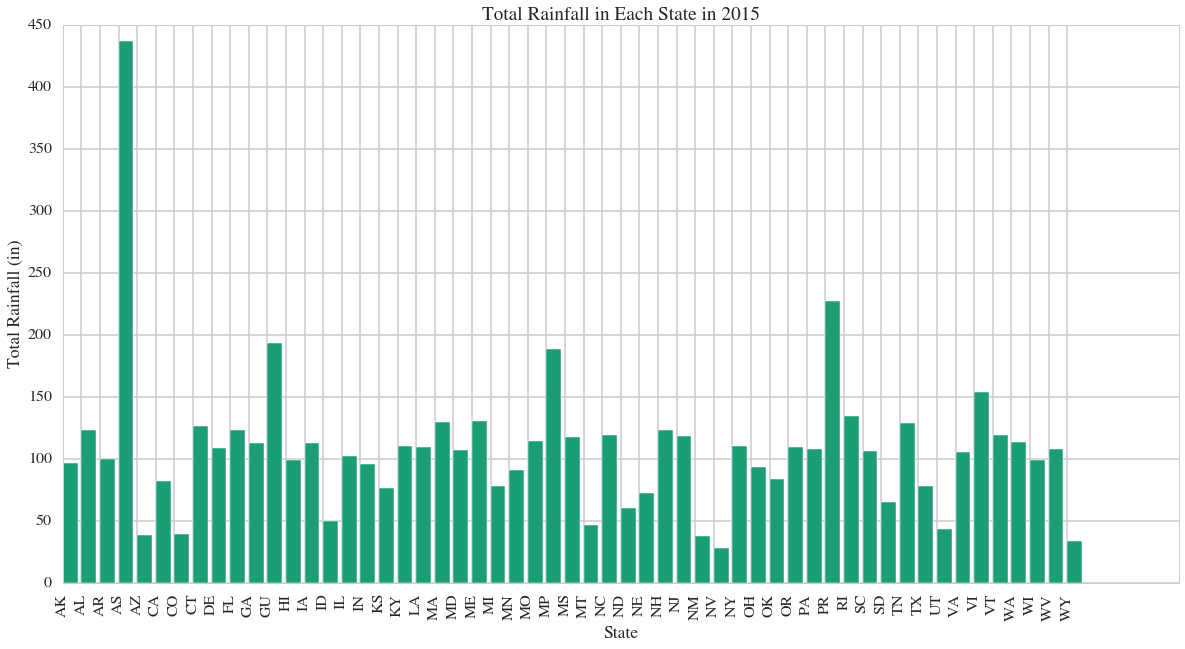

In [30]:
prec_2010 = prec[prec['Year'] == 2010].reset_index()
prec_2010['Total']=(prec_2010.ix[:,"Jan":'Dec']).sum(axis=1)
plt.figure(figsize=(20,10))
plt.bar(prec_2010.index, prec_2010.Total)
plt.xticks(prec_2010.index, prec_2010.State, rotation=90)
plt.xlabel('State')
plt.ylabel('Total Rainfall (in)')
plt.title('Total Rainfall in Each State in 2015')

### 2.2 Visualizing Temperature Data

We will use a heat map and bar graph to visualize the temperature data as well.

In [31]:
temp=pd.read_csv("cleaned_data/tempdf.csv")
temp.head()

,Unnamed: 0,State,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,0,AK,1981,-7.316923,-10.849936,-2.146795,-0.466090,7.246795,11.301154,12.566090,11.463397,6.910577,-0.061474,-7.999615,-11.240769
1,1,AK,1982,-10.096667,-12.740577,-6.355897,-3.707115,4.874872,10.444679,13.082628,11.590128,7.221410,-3.105769,-10.229295,-7.180000
2,2,AK,1983,-10.949359,-9.052115,-6.856731,-1.559167,6.256795,11.532115,13.462115,11.002885,6.548077,-0.134551,-6.825641,-8.156731
3,3,AK,1984,-9.910449,-10.662051,-4.902692,-0.588718,6.524423,11.626667,13.034487,11.729359,7.952244,1.275385,-7.563333,-10.658910
4,4,AK,1985,-7.611731,-10.805769,-4.969167,-1.978077,6.095833,10.585897,13.630897,11.520577,6.658910,-2.034872,-10.239231,-7.453141


In [32]:
for col in temp:
    if (col=='State'):
        temp=temp[(temp[col] != 'FM') & (temp[col] != 'PR') & 
                  (temp[col] != 'UM') & (temp[col] != 'MH') & 
                  (temp[col] != 'PW')]

In [33]:
def make_map_temp(year, start_month, end_month): 
    input_df = temp.loc[temp['Year'] == year]
    input_df['mean_temp'] = (temp.ix[:,start_month:end_month]).mean(axis=1)
    for index, row in input_df.iterrows():
        state_full=states_abbrev[row['State']]
        input_df['State'][index]=state_full
    make_map(input_df.set_index('State').mean_temp,"Mean Temperature by State in Celsius from "+str(start_month)+" to "+str(end_month)+" "+str(year))

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


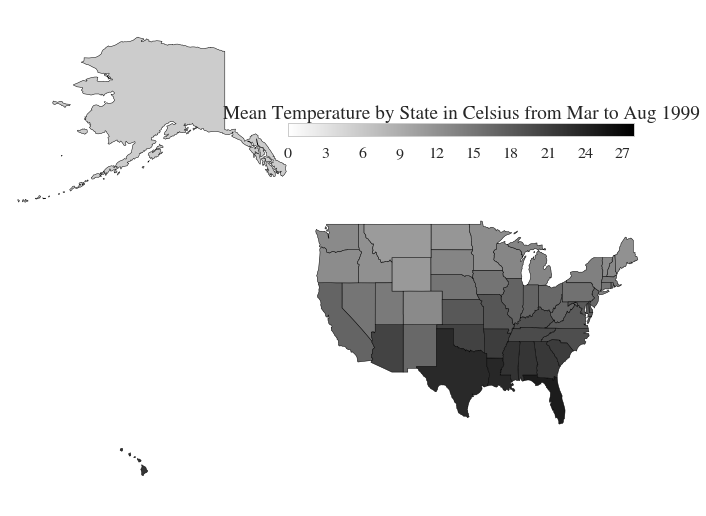

In [34]:
make_map_temp(1999,'Mar','Aug')

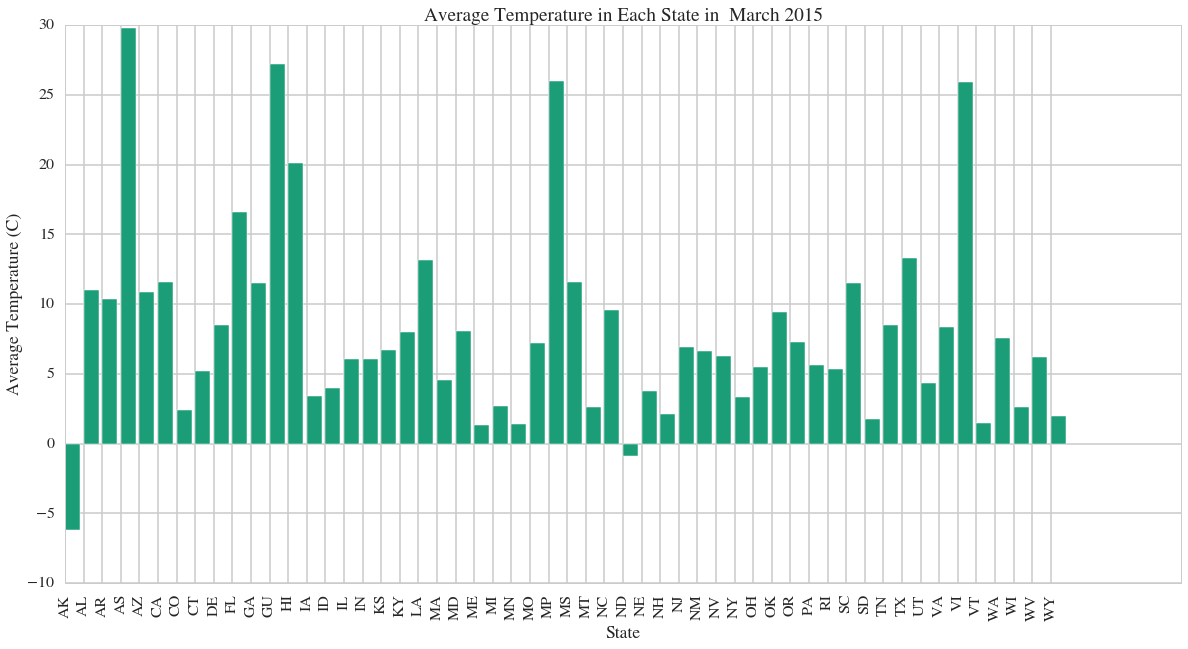

In [35]:
temp_2010 = temp[temp['Year'] == 2010].reset_index()
temp_2010['Total']=(temp_2010.ix[:,"Mar":'Mar']).mean(axis=1)
plt.figure(figsize=(20,10))
plt.bar(temp_2010.index, temp_2010.Total)
plt.xticks(temp_2010.index, temp_2010.State, rotation=90)
plt.xlabel('State')
plt.ylabel('Average Temperature (C)')
plt.title('Average Temperature in Each State in  March 2015')

### 2.3 Visualizing Corn Price Data
Here we will visualize the price of corn using a line graph.

In [39]:
cornprice = pd.read_csv("cleaned_data/cornpricedf.csv")
cornprice_2014 = cornprice[cornprice['year'] == 2014]
cornprice_2014.head()

,Unnamed: 0,price,change,month,year
278,279,198.72,0.62%,Jan,2014
279,280,209.32,5.33%,Feb,2014
280,281,222.33,6.22%,Mar,2014
281,282,222.36,0.01%,Apr,2014
282,283,216.92,-2.45%,May,2014


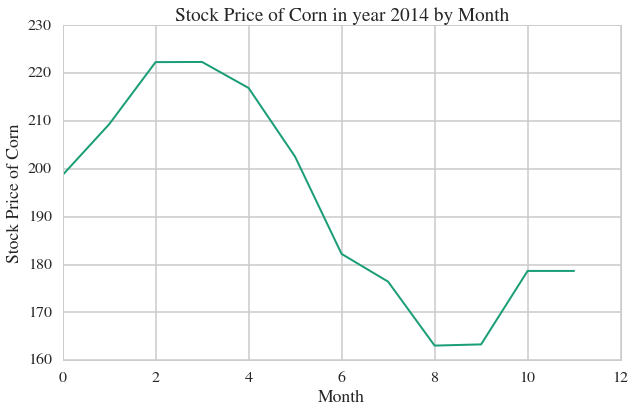

In [38]:
cornprice_2014 = cornprice[cornprice['year'] == 2014]
plt.plot(cornprice_2014.price)
plt.xlabel('Month')
plt.ylabel('Stock Price of Corn')
plt.title('Stock Price of Corn in year 2014 by Month')